# TP4 - Background Substraction
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: AACHARI & JEDDA

### BACKGROUND SUBSTRACTION 

The goal of this TP is to enhance the video of a neurointervention  to improve the visualization of moving tools. To this end you will implement a pipeline of image processing methods to detect the moving tools automatically. 


#### Methodology

As the brain is mostly static one way to detect the moving tools is to substract the background (first image) from each of the subsequent images. However, the results of this step need to be further improved. To this end, you will design a pipilene with the methods learnt in this course to produce a binary mask for the pixels that belong to the tools. 

In your pipeline use at least:
- one histogram transformation
- one morphological operation
- one filtering operation in the spatial domain
- one filtering operation in the spectral domain
- one segmentation method

_The same pipeline should be applied to every image_


#### Expected output

The output of your image processing pipeline should be one binary image mask (with values 0 or 1) for every input image of the sequence, where 
- the zero valued pixels indicate the moving tools inside each image.  
- the pixels with value 1 indicate the background (not a moving tool)

To validate the proposed method, a human has annotated (manually drawn) the tools of interest within the images. The annotated pixels belong either to catheters or guidewires. **Your masks should be as close as possible to the human annotations.**


#### Visualization of data and manual annotations

- Data visualization  (**do not include in final version**): visualize the neurointervention images in the ``` catheter``` folder with name ```frame_#```

- Individual Annotation visualization  (** do not include in final version**): visualize the manual annotations in the ```catheter``` folder with names ``` #_MicroCath``` and ```#_GuideWire```. 

- Individual Annotation visualization  (** do not include in final version**): visualize the full manual annotation (union of the guidewire and microcatheter masks) by composing the union of the ``` #_MicroCath``` and ```#_GuideWire```. It should also be a binary mask.



#### Experimental (quantitative and qualitative  validation)

To compare your results and the manual annotations use the mean SAD (Sum of Absolute Differences) and the SNR (Signal to Noise Ratio) errors between your  mask and  the **full** manual mask. 

Present the results qualitatively and quantitatively:

- Qualitatively: 
     - Show your mask side by side with the manually annotated mask
     - Create an enhanced image suitable for guidance: enhance the contrast of the image and overlay your mask on the green channel of the enhanced image.

- Quantitatively: 
    - compute and print the SAD (sum of absolute differences) error per image. 
    - compute and print the MSE (sum of squared  differences ) error per image.
    - compute and print the PSNR (Peak signal to noise ratio) taking as reference image the manual annotations. 
    - Then compute and print the mean and standard deviation of the three measures (SAD, MSE and PSNR) over the entire sequence.
    
Hints:
```
mse = numpy.mean( (img1 - img2) ** 2 )
PIXEL_MAX = 255.0 #or 1.0 or max over the signal of interest
psnr = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
```
or look at ```skimage.measure``` module

You may use modules such as ```scipy```, ```skimage``` or ``sklearn``(e.g. for clustering with K-means or a Gaussian Mixture Model). Ask me for other external modules.


### REPORT INSTRUCTIONS

#### 1. Intermediate Steps (Code and Description)
Report the results of the intermediate steps (when you add or remove a method from the pipeline):
- provide a text introduction with the idea that you intend to try
- show the implementation of the idea with code 
- evaluate the quantitative and qualitative changes  when including, varying, adapting, etc the proposed method
- Discuss the scores or visualization improvements/degradations 

#### 2. Final Pipeline (Code and Description)
Provide a detailed description of the best performing pipeline. Comment the code such that it is straightforward to relate the pipeline description to the code. Add your conclusions

- Describe the final retained pipeline
- Give a justification for every step (e.g. supported by experimental intermediate steps or theory). 
- Add the **commented** code
- Display the qualitative and quantitative results 
- Give your conclusions

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.io as io
import numpy.random
from scipy import stats
from PIL import Image
from skimage.morphology import  closing, skeletonize, disk
from scipy import ndimage
from skimage import exposure
from skimage.feature import canny
from skimage import filters
from skimage.color import gray2rgb


In [51]:
IMDIR = "./images/" ##Directory containing all the data (frames+ guides_wires+micro_caths)

In [3]:
######### DATA LOADING ############

# Reading all frames and saving them in the array "frames" (PIL Image objects)
frames = []
for i in range(10):
    frame = Image.open(IMDIR+"frame_2"+str(i)+"1")
    frames.append(frame)
    
# Constructing the full manual masks and saving them in the array "fullMasks" (PIL Image objects)
manualMasks = []
for i in range(10):
    guideWire = Image.open(IMDIR+"2"+str(i)+"1"+"_GuideWire.tiff").convert('L')
    microCath = Image.open(IMDIR+"2"+str(i)+"1"+"_MicroCath.tiff").convert('L')
    fullMask = Image.blend(microCath, guideWire, 0.5)
    manualMasks.append(fullMask) 

In [52]:
######### FUNCTION + PIPELINE ##########

#Convert PIL Image object to numpy array the convert type to float32
def floatArray(image):
    im = np.asarray(image)
    im = im.astype('float32')
    return im

#computes SAD where im1, im2 are numpy arrays (dived )
def sad(im1,im2):
    return np.sum(np.abs(im1- im2))

#computes MSE where im1, im2 are numpy arrays
def mse(im1,im2):
    return numpy.mean( (im1 - im2) ** 2 )

#computes PSNR where original, ref are numpy arrays
def psnr(original, ref):
    MAX = np.max(original)
    MSE = mse(original, ref)
    return 20*np.log10(MAX/(np.sqrt(MSE)))


"""Segmentation pipline 
parameters : - frame : frame to segment (PIL Image object)
             - back : background (PIL Image object)
             
return : binary mask (numpy array) """

def pipeline(frame, back=frames[0]):
    #convert to numpy arrays with type float32
    back = floatArray(back)
    frame = floatArray(frame)

    #substract the background from the frame
    im = frame-back
    
    #Histogram Transfromation
    #Contrast stretching 
    p1, p2 = np.percentile(im, (0, 6))    
    im = exposure.rescale_intensity(im, in_range=(p1, p2))
     
    #Frequency Domain Filetring 
    #low pass Butterworth n=8 to denoise while preserving edges (the moving tool)
    im = filters.butterworth(im, cutoff_frequency_ratio=0.4,  high_pass=False, order=8)

    #Spatial Domain Filtering 
    #Gaussian filtering to prepare for segmentation (local thresholding)
    im = filters.gaussian(im,sigma=0.5)

    #Segmentation
    #local thresholding,calculates thresholds in regions with a characteristic size block_size
    #surrounding each pixel.Each threshold value is the weighted mean of the local neighborhood minus an offset value.
    block_size = 21
    local_thresh = filters.threshold_local(im, block_size, offset=0.1)
    im = im > local_thresh

    #Morphology Transformation 1
    #opening transformation to remove small block dots from the final mask
    selem = np.array([[1, 1]])
    im = closing(im,selem)

    #Morphology Transformation 2
    #skeletonizing transformation to make the final mask more thin in order to match the manual mask 
    im = im < 1
    im = skeletonize(im)
    im = im <1
    
    return im



--Measures over the entire sequence--
SAD : mean=628.98, standard deviation=275.80
MSE : mean=0.00188, standard deviation=0.00088
PSNR : mean=28.06, standard deviation=3.08


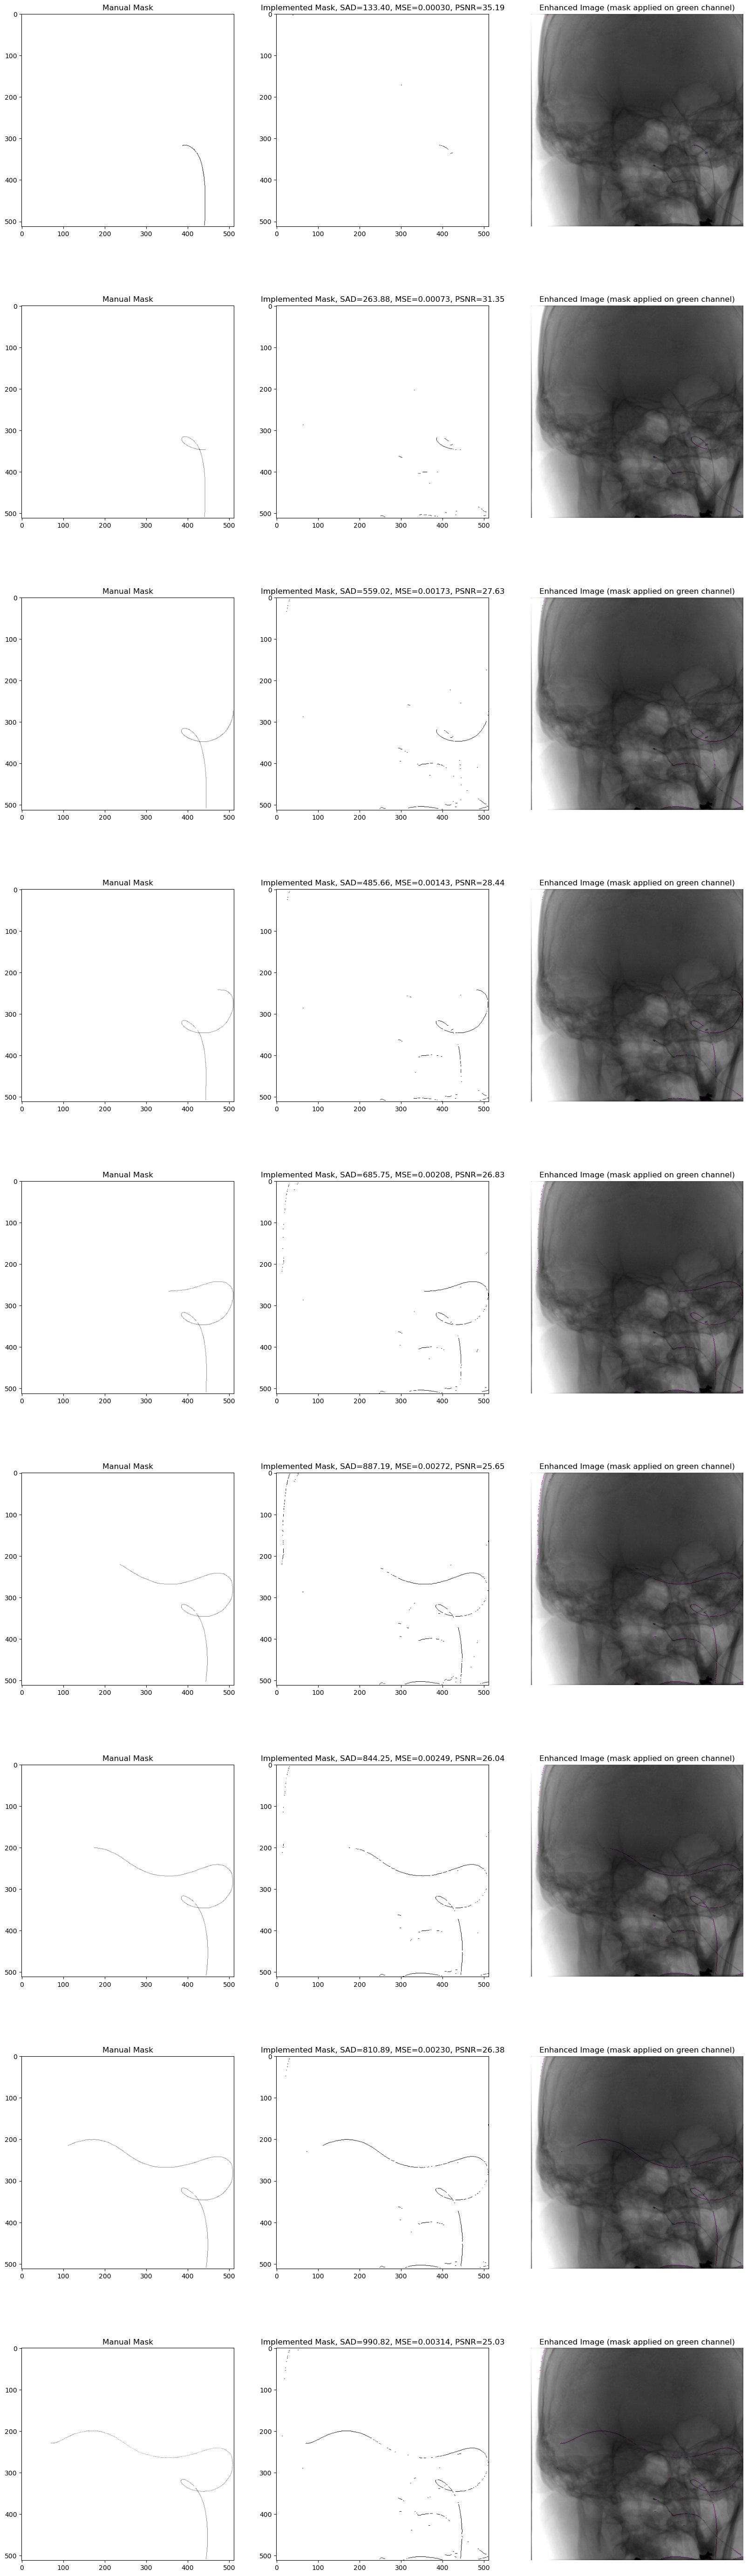

In [53]:
######### RESULTS VISUALISATION ##########

#figure parameters
width=20
height=80
plt.rcParams['figure.figsize'] = [width, height]

#create a figure
fig=plt.figure()

#arrays storing the 3 measures in order to compute their mean and standard deviation over the entire sequence
mseArray = []
sadArray=  []
psnrArray = []

#looping through the 9 available frames to segment
counter = 1;
for i in range(1,10):
    
    #implemented and manual masks (numpy arrays)
    binaryMask = pipeline(frames[i])
    manualMask = np.asarray(manualMasks[i])
    manualMask = manualMask.astype(float) / 255
    
    #SAD, MSE, MSR
    SAD = sad(binaryMask, manualMask)
    sadArray.append(SAD)
    MSE = mse(binaryMask, manualMask)
    mseArray.append(MSE)
    PSNR = psnr(binaryMask, manualMask)
    psnrArray.append(PSNR)

    #display manual mask
    plt.subplot(10,3,counter)
    plt.imshow(manualMask, cmap='gray')
    plt.title('Manual Mask')
    counter += 1
    
    #display implemented mask with the 3 measures
    plt.subplot(10,3,counter)
    plt.imshow(binaryMask, cmap='gray')
    plt.title('Implemented Mask, SAD={0:0.2f}, MSE={1:0.5f}, PSNR={2:0.2f}'.format(SAD,MSE,PSNR))
    counter += 1
    
    #contrast stretching to enhance the current frame
    enhancedIm = exposure.rescale_intensity(np.asarray(frames[i]))
    #transform the current frame from graysclae to RGB
    rgbIm = gray2rgb(enhancedIm)
    #applying the implemented mask on green channel
    rgbIm[:,:,1] = rgbIm[:,:,1] * binaryMask

    #display the enhanced frame suitable for guidance
    plt.subplot(10,3,counter)
    plt.imshow(rgbIm)
    plt.axis('off')
    plt.title('Enhanced Image (mask applied on green channel)')
    counter += 1

#computing and displaying the 3 global measures 
meanSAD = np.mean(sadArray)
stdSAD = np.std(sadArray)
meanMSE = np.mean(mseArray)
stdMSE = np.std(mseArray)
meanPSNR = np.mean(psnrArray)
stdPSNR = np.std(psnrArray)

print('--Measures over the entire sequence--')
print('SAD : mean={0:0.2f}, standard deviation={1:0.2f}'.format(meanSAD, stdSAD))
print('MSE : mean={0:0.5f}, standard deviation={1:0.5f}'.format(meanMSE, stdMSE))
print('PSNR : mean={0:0.2f}, standard deviation={1:0.2f}'.format(meanPSNR, stdPSNR))

######## DOUBLE CLICK ON FIGURES (ESPECIALLY THE ENHACED IMAGE) FOR A CLEAR VIEW ##########